In [ ]:
from google.colab import files
files.upload()

!unzip -q hacklive_AV_Dataset.zip

Saving hacklive_AV_Dataset.zip to hacklive_AV_Dataset.zip


In [ ]:
!pip install -q catboost
!pip install -q --upgrade seaborn

     |████████████████████████████████| 66.1MB 56kB/s 
     |████████████████████████████████| 286kB 2.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [ ]:
ss = pd.read_csv('SampleSubmission_XkIpo3X.csv')
train = pd.read_csv('Train_eP48B9k.csv')
test = pd.read_csv('Test_jPKyvmK.csv')

In [ ]:
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

num_cols = [c for c in features if c not in cat_cols]

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):
 
  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

### **C. Classification Models.**


There are a lot of classification models that can be used, many of them such as Gradient Boosting Models and Neural Networks are be used to win competitions. However, for the purpose of creating a baseline classification model, we will make the following:

1. Logistic Regression.
2. Decision Tree

In [ ]:
train.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0


In [ ]:
?pd.get_dummies

In [ ]:
pd.get_dummies(train[['job_type']])

,job_type_admin.,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,job_type_unemployed,job_type_unknown
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31642,1,0,0,0,0,0,0,0,0,0,0,0
31643,0,0,0,0,1,0,0,0,0,0,0,0
31644,0,0,0,0,0,0,0,0,0,0,1,0
31645,0,0,0,0,0,0,0,1,0,0,0,0


**Steps to Make a Baseline Classification Model**

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a classification Model on train, check its results on validation set.

7. Predict for the test set.


Lets complete each of these steps one by one.

**1. Concating/Joining train and test datasets.**


In [ ]:
train.shape, test.shape

((31647, 18), (13564, 17))

In [ ]:
31647 + 13564

45211

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(45211, 18)

In [ ]:
df

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0.0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0.0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0.0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,id_42406,29.0,management,single,tertiary,no,717.0,yes,no,cellular,15,jun,94.0,1.0,NaN,0,unknown,NaN
45207,id_14483,NaN,blue-collar,married,secondary,no,604.0,yes,no,telephone,10,jul,155.0,1.0,NaN,0,unknown,NaN
45208,id_43066,45.0,blue-collar,married,primary,no,237.0,yes,no,unknown,16,may,231.0,4.0,NaN,0,unknown,NaN
45209,id_18375,52.0,admin.,married,primary,no,241.0,yes,no,cellular,13,may,243.0,2.0,299.0,5,failure,NaN


**2. Encoding categorical columns.**

There are multiple ways to encoded categorical variables. For the sake of simplicity, we will be using One-Hot Encoding.

In [ ]:
df = pd.get_dummies(df, columns = cat_cols)

In [ ]:
df.head()

,id,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,term_deposit_subscribed,job_type_admin.,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,job_type_unemployed,job_type_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_loan_no,housing_loan_yes,personal_loan_no,personal_loan_yes,communication_type_cellular,communication_type_telephone,communication_type_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown
0,id_43823,28.0,285.0,26,303.0,4.0,NaN,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,id_32289,34.0,934.0,18,143.0,2.0,132.0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,id_10523,46.0,656.0,5,101.0,4.0,NaN,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,id_43951,34.0,2.0,20,127.0,3.0,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,id_40992,41.0,1352.0,13,49.0,2.0,NaN,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
df.shape

(45211, 53)

**3. Filling Null Values**

As seen earlier in our EDA, our dataset contains null values. There could be multiple ways to fill our Null Values, but for now we will fill it with a large negative random number say -999

In [ ]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

**4. Split the processed dataset back into train and test datasets.**

The first train.shape[0] of df are rows that belong to train and the rest are those that belong to test

In [ ]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
len(features)

51

**5. Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [ ]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1, stratify = train_proc[TARGET_COL])

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

**6. Fit a classification Model on train, check its results on validation set.**

##### **6A. Logistic Regression**

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

https://en.wikipedia.org/wiki/Logistic_regression

Normalizing and print coefs

height: 170cm, 180cm

weight: 50 kg, 60 kg, 70 kg

In [ ]:
X_trn.head()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,job_type_admin.,job_type_blue-collar,job_type_entrepreneur,job_type_housemaid,job_type_management,job_type_retired,job_type_self-employed,job_type_services,job_type_student,job_type_technician,job_type_unemployed,job_type_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_loan_no,housing_loan_yes,personal_loan_no,personal_loan_yes,communication_type_cellular,communication_type_telephone,communication_type_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown
21182,53.0,4963.0,8,98.0,1.0,333.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4607,40.0,2152.0,5,310.0,2.0,169.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
14135,43.0,3.0,30,204.0,1.0,259.0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
22687,30.0,6103.0,27,344.0,1.0,-999.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2842,41.0,569.0,17,458.0,1.0,-999.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_trn.shape

(25317, 51)

In [ ]:
X_trn[:,0]

array([0.22766931, 0.13722697, 0.15809828, ..., 0.2137551 , 0.26245482,
       0.19288379])

In [ ]:
clf = LogisticRegression(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.4720379146919431

0.47, not bad. Much better than our rule based classifier of score 30

**0.463**, again near our validation score, its nice we are improving

##### **6B. Decision Tree**

A Decision Tree is a flowchart like structure, where each node represents a decision, each branch represents an outcome of the decision, and each terminal node provides a prediction / label.

https://courses.analyticsvidhya.com/courses/getting-started-with-decision-trees

Although trees don't require the data to be normalized, since our data is already normalized we will work with that.

In [ ]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.4971014492753624

Decision Trees so far have given us the best validation score. 

**0.4812**, slight improvement over our Logistic Regression scores

# **Hyperparameter Tuning**

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:
```
max_depth: [6, 9, 12, 15]
learning_rate: [0.0001, 0.005, 0.01, 0.05]
```

etc.

## **1. Grid Search**

In grid search we try all possible combinations from the values of hyperparameters provided, to find the optimal hyper-parameter combination. However as the number of hyperparameters and their possible values grows, doing a grid search becomes infeasible.

Consider there are 5 hyperparameters to tune, and each of them 5 have different possible values.

Then total possible combinations of hyperparameters will be:

5 x 5 x 5 x 5 x 5 = 3125.

So you will have to wait for your model to run 3125 times, before getting the optimal set of hyperparameters.

If you still think you want to run it these many times, you are most welcome :)


# **2. Random Search**

In random search we will run our model only a fixed number of times, say 10, and among these 10 runs we will return the best hyper-parameter combination. Yes, you are right, this may not be the optimal hyper-parameter combination. But, it saves much more time, so we will go for random search.

In [ ]:
?DecisionTreeClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}

In [ ]:
optimal_params = {'class_weight': {0: 1, 1: 3},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 32,
 'min_samples_split': 20}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = clf.fit(X_trn, y_trn)

preds_val = clf.predict(X_val)

f1_score(y_val, preds_val)

0.5991661703394877

**0.60**, that's quite a boost, a big boost , hyperparameter tuning is definitely important

**Exercise**

Try the same thing, i.e. RandomSearchCV for Logistic Regression.

* Does the performance improve over basic LogisticRegression ?
* Does the performance improve over DecisionTree ?

Try other Classifiers in Scikit-Learn such as SVMs, Naive-Bayes, NNs, RandomForests etc. Then try to answer the following questions.

* Which algorithm performs the best ?
* Which algorithm takes the longest to run ?

# **Validation Strategy.**

**Problems with simple train_test_split validation**

* We are not using complete 100 % of the dataset for training. More data implies more performance, if the data quality is good.

* We are not using complete 100 % of the dataset for validation. Our validation now is biased towards the validation set we have got through train_test_split. What if the test set is different from the validation set ?


## **K-Fold Validation**



Now for each of these parts, we take them as validation one by one and rest of the parts for training. The unshaded or white box, represents the part among A, B, C, D, and E, that we take for validation. Rest are used for training in that particular fold.
Then we make two predictions (shown in the right hand side of the diagram):

**1. Predictions for the validation set:** This is also known as out-of-fold prediction.


Finally if we combine the predictions for each of these folds we get OOFs or Out-of-Folds predictions. This is the prediction for the entire dataset. We can now see the performance our classifier on the entire training set.

Also we take the mean of the test predictions for each fold, and get our final test_predictions. We then need to round it to 0 or 1, since our metric demands we submit a discrete output, ie. no probabilities. 

## **Stratified K-Fold.**

One obvious problem with normal KFold, is that each in each fold the distribution of classes in the validation set, will be not be same. This is a big problem with imbalanced datasets. 

In our above example its possible that in any of the splits we could have could have a validation set with no positive examples. 

To overcome this problem we will use Stratified-KFold Validation. StratifiedKFold ensures that each of the splits have same proportion of examples of each class.



On a side note seeing so many arrows, reminds of Neural Networks.

Lets make our Decision Tree Model with Stratified KFold Validation

**Function to Run KFold**

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

**KFold on Decision Tree**

In [ ]:
target = train[TARGET_COL]

In [ ]:
dt_params = {'class_weight': {0: 1, 1: 3},
             'criterion': 'gini',
             'max_depth': 10,
             'max_features': 0.8,
             'max_leaf_nodes': 32,
             'min_samples_split': 20,
             'random_state': 1
             }

clf = DecisionTreeClassifier(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.5905905905905906

------------- Fold 2 -------------

F1 score for validation set is 0.6178307779670643

------------- Fold 3 -------------

F1 score for validation set is 0.5911330049261083

------------- Fold 4 -------------

F1 score for validation set is 0.5931428571428572

------------- Fold 5 -------------

F1 score for validation set is 0.5881045025013897


F1 score for oofs is 0.5958449346755194


**0.5838**, little worse than our best LB score, but not much of a difference

# **Gradient Boosting**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

 ## **LightGBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel and GPU learning.

* Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

F1 score for validation set is 0.5797101449275361

------------- Fold 2 -------------

F1 score for validation set is 0.5985518905872887

------------- Fold 3 -------------

F1 score for validation set is 0.5746753246753248

------------- Fold 4 -------------

F1 score for validation set is 0.5987055016181231

------------- Fold 5 -------------

F1 score for validation set is 0.5623471882640587


F1 score for oofs is 0.5828478964401295


In [ ]:
preds = np.array([0.2, 0.4, 0.35, 0.7, 0.21])
preds.round()

array([0., 0., 0., 1., 0.])

### **Hacking F1_Score or Threshold optimization**

Rounding off means you are selecting a threshold of 0.5. Any predictions with probabilities greater than or equal to 0.5 will be rounded to 1, rest will be rounded to 0.

But is 0.5 the best threshold to get an optimal F1-score ?

Lets verify it ourselves by running all threholds from 0.01,0.02 to 0.99.

In [ ]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1
  thresh_score = f1_score(target, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.19371593276447588
Threshold 0.01: 0.402852897473997
Threshold 0.02: 0.480711743772242
Threshold 0.03: 0.5229929851909586
Threshold 0.04: 0.5470043439062371
Threshold 0.05: 0.5652543814871533
Threshold 0.06: 0.5774080560420315
Threshold 0.07: 0.588689407540395
Threshold 0.08: 0.5969027765050857
Threshold 0.09: 0.6052557748059478
Threshold 0.1: 0.6131859756097561
Threshold 0.11: 0.6179240702980872
Threshold 0.12: 0.6228182624987674
Threshold 0.13: 0.627392044885282
Threshold 0.14: 0.6309039087947882
Threshold 0.15: 0.6322633914748684
Threshold 0.16: 0.6337276248298963
Threshold 0.17: 0.6366436537440254
Threshold 0.18: 0.6390710676271368
Threshold 0.19: 0.6401391606871059
Threshold 0.2: 0.6435894609194136
Threshold 0.21: 0.6456798392498325
Threshold 0.22: 0.6452050152490681
Threshold 0.23: 0.6462135036496351
Threshold 0.24: 0.6475419317524581
Threshold 0.25: 0.6483889865260692
Threshold 0.26: 0.6486165538534615
Threshold 0.27: 0.6495130455693159
Threshold 0.28: 0.64847746

In [ ]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.27


0.6495130455693159

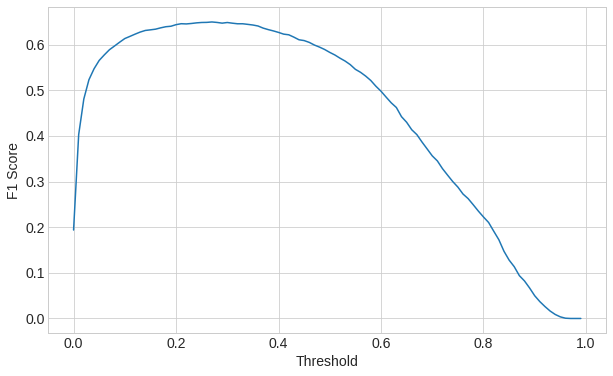

In [ ]:
optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
f1_score(target, (lgb_oofs > optimal_thresh) * 1)

**0.6616**, now that's the LGB we know.

    ### **Tuning LightGBM**

    * Early Stopping: Stopping the model training, when the model starts to overfit
      * How do we know if model is overfitting ?
    * HyperParameter Optimization.
      * Is random search the best way to go ?

**Simple Function to Run Gradient Boosting**

Let's make a simple function to call gradient boosting and get our oofs and predictions. Rather than copying and pasting the same code again and again/

In [ ]:
def run_gradient_boosting(clf, fit_params, train, test, features):
    N_SPLITS = 5
    oofs = np.zeros(len(train_proc))
    preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        preds_test = clf.predict_proba(X_test)[:, 1]

        fold_score = f1_score(y_val, preds_val.round())
        print(f'\nF1 score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS


    oofs_score = f1_score(target, oofs.round())
    print(f'\n\nF1 score for oofs is {oofs_score}')

    return oofs, preds

**Manual Tuning. Choosing Hyperparameters to Tune**


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.167919
[200]	valid_0's binary_logloss: 0.165527
[300]	valid_0's binary_logloss: 0.165441
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.165302

F1 score for validation set is 0.5844897959183674

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.165002
[200]	valid_0's binary_logloss: 0.159994
[300]	valid_0's binary_logloss: 0.1601
Early stopping, best iteration is:
[241]	valid_0's binary_logloss: 0.159718

F1 score for validation set is 0.5933170334148329

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.169094
[200]	valid_0's binary_logloss: 0.164644
[300]	valid_0's binary_logloss: 0.163774
[400]	valid_0's binary_logloss: 0.163958
Early stopping, best iteration is:
[327]	

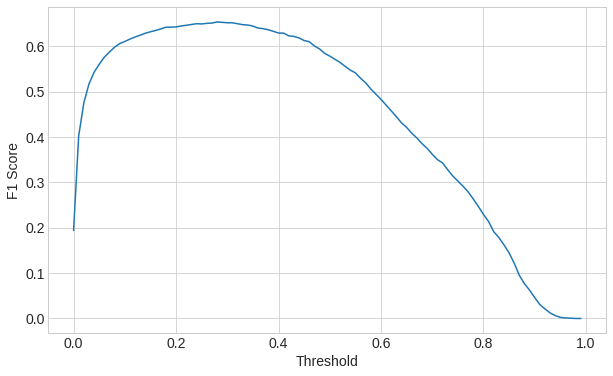

In [ ]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**0.6559**, CV increased but LB decreased :(

**Tuning Learning Rate**


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.191005
[400]	valid_0's binary_logloss: 0.173029
[600]	valid_0's binary_logloss: 0.167575
[800]	valid_0's binary_logloss: 0.165652
[1000]	valid_0's binary_logloss: 0.165193
[1200]	valid_0's binary_logloss: 0.165259
Early stopping, best iteration is:
[1073]	valid_0's binary_logloss: 0.165143

F1 score for validation set is 0.5901639344262296

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.189294
[400]	valid_0's binary_logloss: 0.169347
[600]	valid_0's binary_logloss: 0.162194
[800]	valid_0's binary_logloss: 0.159335
[1000]	valid_0's binary_logloss: 0.158345
[1200]	valid_0's binary_logloss: 0.157803
[1400]	valid_0's binary_logloss: 0.157511
[1600]	valid_0's binary_logloss: 0.157439
[1800]	valid_0's binary_logloss: 0.157614
Early stopping, best iteration is:
[1659]	valid_0's 

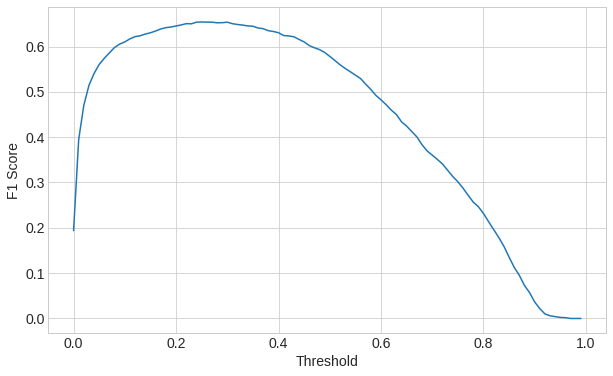

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 2)
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**0.6585**, CV and LB both increased

Enough of LightGBM, lets now look at other libraries

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/


------------- Fold 1 -------------
0:	learn: 0.6813125	test: 0.6812521	best: 0.6812521 (0)	total: 75.6ms	remaining: 3m 46s
200:	learn: 0.2051442	test: 0.2051839	best: 0.2051839 (200)	total: 3.35s	remaining: 46.6s
400:	learn: 0.1820961	test: 0.1849985	best: 0.1849985 (400)	total: 6.34s	remaining: 41.1s
600:	learn: 0.1714202	test: 0.1779313	best: 0.1779313 (600)	total: 9.35s	remaining: 37.3s
800:	learn: 0.1636347	test: 0.1733997	best: 0.1733997 (800)	total: 12.3s	remaining: 33.8s
1000:	learn: 0.1579302	test: 0.1706201	best: 0.1706201 (1000)	total: 15.4s	remaining: 30.7s
1200:	learn: 0.1528147	test: 0.1683943	best: 0.1683932 (1198)	total: 18.4s	remaining: 27.5s
1400:	learn: 0.1484515	test: 0.1668977	best: 0.1668977 (1400)	total: 21.4s	remaining: 24.4s
1600:	learn: 0.1445013	test: 0.1658762	best: 0.1658762 (1600)	total: 24.4s	remaining: 21.3s
1800:	learn: 0.1406907	test: 0.1652143	best: 0.1652061 (1796)	total: 27.4s	remaining: 18.2s
2000:	learn: 0.1374177	test: 0.1647245	best: 0.1647245 (

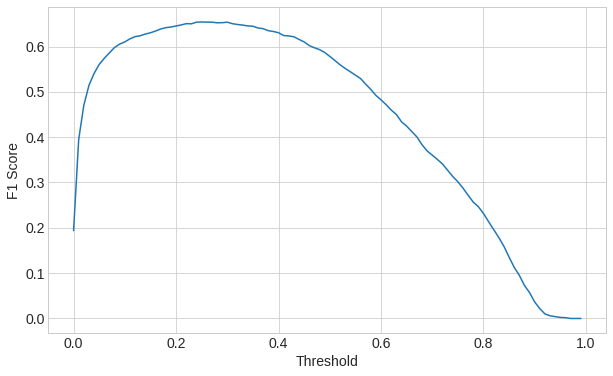

In [ ]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**0.6620**, amazing improvement in both CV and LB

**CatBoost: gives Improvement from 0.6585 to 0.6620**.

* Is catboost better then LightGBM ?
* Can catboost score be further improved ?
* Can LighGBM be tuned to give a better score than CatBoost ?

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/


------------- Fold 1 -------------
[0]	validation_0-error:0.097788
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.077409
[400]	validation_0-error:0.080411
Stopping. Best iteration:
[205]	validation_0-error:0.077251


F1 score for validation set is 0.5880370682392586

------------- Fold 2 -------------
[0]	validation_0-error:0.097156
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.079305
[400]	validation_0-error:0.079147
Stopping. Best iteration:
[360]	validation_0-error:0.077409


F1 score for validation set is 0.5983606557377049

------------- Fold 3 -------------
[0]	validation_0-error:0.099226
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.086428
[400]	validation_0-error:0.083109
[600]	validation_0-error:0.083425
Stopping. Best iteration:
[515]	validation_0-error:0.081845


F1 score for validation set is 0.5711920529801325

------------- Fold 4

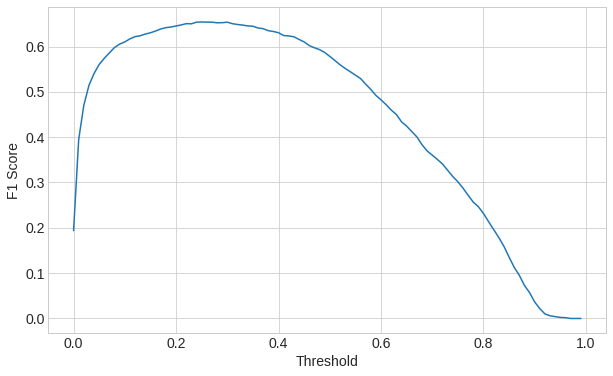

In [ ]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**0.655**, decrease in both CV and LB

**Questions to think about XGBoost**

* Is XGBoost worse than LightGBM and CatBoost ?

* Can XGBoost be tuned more ?



# **Feature Engineering**

* What does a model know about a sample ?

* What the model does not know about the sample ?

* How do we provide that unknown information to the model ?


***Feature Engineering is one of the biggest difference maker in any ML competition.*** 

<br>
<br>

**Helper Functions**

In [ ]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [ ]:
cat_cols

['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [ ]:
train.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0


In [ ]:
df, features = join_df(train, test)

In [ ]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0.0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0.0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0.0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0.0


In [ ]:
df.select_dtypes('object').columns.tolist()

['id',
 'job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [ ]:
df, features = join_df(train, test)

### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

#### No NaN filling required.

In [ ]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,0,0,0,0,285.0,0,0,0,26,0,303.0,4.0,NaN,0,0,0.0
1,id_32289,34.0,1,1,1,0,934.0,1,1,1,18,1,143.0,2.0,132.0,1,1,0.0
2,id_10523,46.0,2,1,1,0,656.0,1,0,1,5,2,101.0,4.0,NaN,0,0,0.0
3,id_43951,34.0,3,0,1,0,2.0,0,0,0,20,3,127.0,3.0,NaN,0,0,0.0
4,id_40992,41.0,1,1,2,0,1352.0,0,0,1,13,3,49.0,2.0,NaN,0,0,0.0


## **Frequency Features**

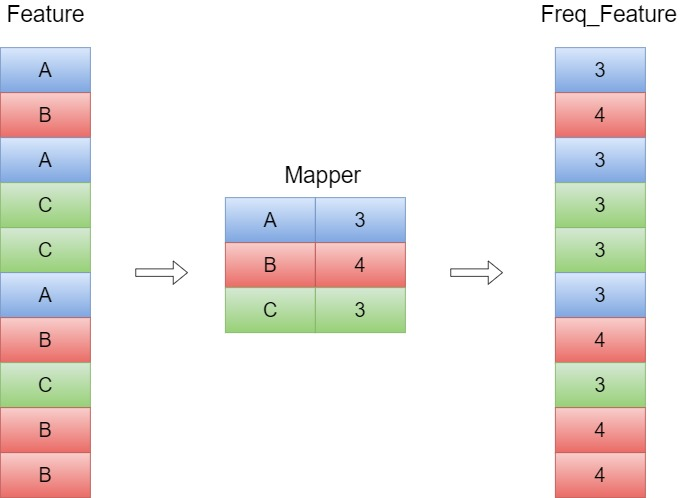

In [ ]:
df['job_type'].value_counts()

1     9732
0     9458
2     7597
6     5171
3     4154
4     2264
9     1579
5     1487
11    1303
8     1240
7     938 
10    288 
Name: job_type, dtype: int64

In [ ]:
df['job_type'].head()

0    0
1    1
2    2
3    3
4    1
Name: job_type, dtype: int64

In [ ]:
df['job_type'].map(df['job_type'].value_counts())

0        9458
1        9732
2        7597
3        4154
4        9732
         ... 
45206    9458
45207    9732
45208    9732
45209    5171
45210    7597
Name: job_type, Length: 45211, dtype: int64

In [ ]:
def get_frequency_features(df, cols):

  df[[c + '_freq' for c in cols]] = df[cols].apply(lambda x: x.map(x.value_counts()))
  
  return df

In [ ]:
freq_cols = [c for c in df.columns if (train[c].nunique() > 10) and (train[c].nunique() < 50)]
freq_cols

['job_type',
 'day_of_month',
 'month',
 'num_contacts_in_campaign',
 'num_contacts_prev_campaign']

In [ ]:
df = get_frequency_features(df, freq_cols)
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.205458
[400]	valid_0's binary_logloss: 0.180558
[600]	valid_0's binary_logloss: 0.170463
[800]	valid_0's binary_logloss: 0.166534
[1000]	valid_0's binary_logloss: 0.164775
[1200]	valid_0's binary_logloss: 0.163737
[1400]	valid_0's binary_logloss: 0.163092
[1600]	valid_0's binary_logloss: 0.162731
[1800]	valid_0's binary_logloss: 0.162783
Early stopping, best iteration is:
[1725]	valid_0's binary_logloss: 0.162697

F1 score for validation set is 0.5839536807278743

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.20425
[400]	valid_0's binary_logloss: 0.17895
[600]	valid_0's binary_logloss: 0.168815
[800]	valid_0's binary_logloss: 0.164977
[1000]	valid_0's binary_logloss: 0.163323
[1200]	valid_0's binary_logloss: 0.161824
[1400]	valid_0's binary_logloss: 0.161171
[1600]	valid

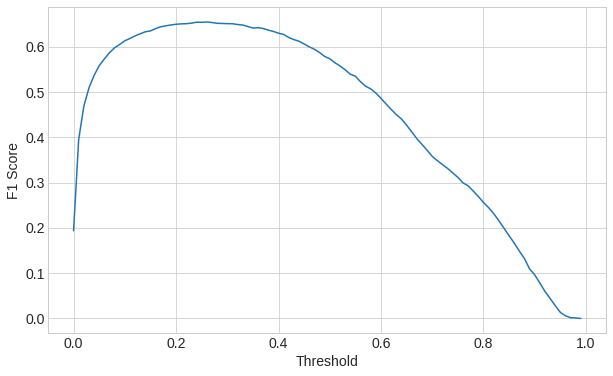

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.4,
                        reg_alpha = 1,
                        reg_lambda = 1
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

## **Interaction Features**

Can any two features be combined to make more sense in the given dataset ?

In [ ]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,job_type_freq,day_of_month_freq,month_freq,num_contacts_in_campaign_freq,num_contacts_prev_campaign_freq
0,id_43823,28.0,0,0,0,0,285.0,0,0,0,26,0,303.0,4.0,NaN,0,0,0.0,9458,1035,5341,3510.0,36954
1,id_32289,34.0,1,1,1,0,934.0,1,1,1,18,1,143.0,2.0,132.0,1,1,0.0,9732,2308,3970,12454.0,2772
2,id_10523,46.0,2,1,1,0,656.0,1,0,1,5,2,101.0,4.0,NaN,0,0,0.0,7597,1910,2649,3510.0,36954
3,id_43951,34.0,3,0,1,0,2.0,0,0,0,20,3,127.0,3.0,NaN,0,0,0.0,4154,2752,13766,5502.0,36954
4,id_40992,41.0,1,1,2,0,1352.0,0,0,1,13,3,49.0,2.0,NaN,0,0,0.0,9732,1585,13766,12454.0,36954


In [ ]:
df[['month', 'day_of_month']].head()

,month,day_of_month
0,0,26
1,1,18
2,2,5
3,3,20
4,3,13


In [ ]:
df['month_and_day_of_month'] = pd.factorize(df['month'].astype('str') + df['day_of_month'].astype('str'))[0]

In [ ]:
df['month_and_day_of_month']

0        0  
1        1  
2        2  
3        3  
4        4  
        ..  
45206    139
45207    41 
45208    108
45209    4  
45210    92 
Name: month_and_day_of_month, Length: 45211, dtype: int64

In [ ]:
df['month_and_day_of_month'].nunique()

311

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207034
[400]	valid_0's binary_logloss: 0.179554
[600]	valid_0's binary_logloss: 0.169858
[800]	valid_0's binary_logloss: 0.165635
[1000]	valid_0's binary_logloss: 0.163723
[1200]	valid_0's binary_logloss: 0.162504
[1400]	valid_0's binary_logloss: 0.16176
[1600]	valid_0's binary_logloss: 0.161409
[1800]	valid_0's binary_logloss: 0.161364
[2000]	valid_0's binary_logloss: 0.161416
Early stopping, best iteration is:
[1664]	valid_0's binary_logloss: 0.161346

F1 score for validation set is 0.582716049382716

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.204002
[400]	valid_0's binary_logloss: 0.176246
[600]	valid_0's binary_logloss: 0.166566
[800]	valid_0's binary_logloss: 0.162407
[1000]	valid_0's binary_logloss: 0.160111
[1200]	valid_0's binary_logloss: 0.158753
[1400]	valid

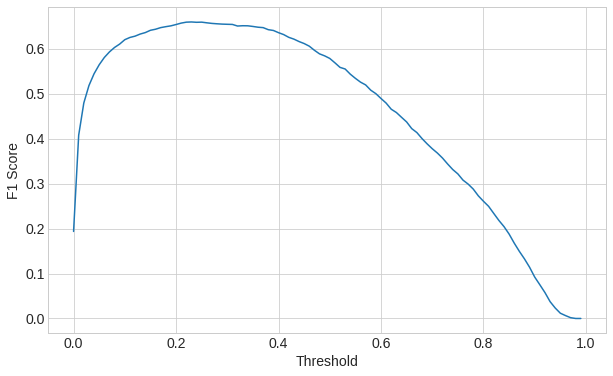

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**EDA and features from EDA**

In [ ]:
df['month_and_day_of_month'].value_counts()

47     1126
31     1011
4      1002
11     891 
45     841 
      ...  
308    1   
309    1   
293    1   
310    1   
300    1   
Name: month_and_day_of_month, Length: 311, dtype: int64

In [ ]:
df = get_frequency_features(df, ['month_and_day_of_month'])
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})

0        3.0
1        2.0
2        2.0
3        2.0
4        1.0
        ... 
31642    2.0
31643    3.0
31644    1.0
31645    2.0
31646    3.0
Name: education, Length: 31647, dtype: float64


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.207293
[400]	valid_0's binary_logloss: 0.178549
[600]	valid_0's binary_logloss: 0.169959
[800]	valid_0's binary_logloss: 0.165109
[1000]	valid_0's binary_logloss: 0.163458
[1200]	valid_0's binary_logloss: 0.161927
[1400]	valid_0's binary_logloss: 0.161026
[1600]	valid_0's binary_logloss: 0.160614
[1800]	valid_0's binary_logloss: 0.160538
[2000]	valid_0's binary_logloss: 0.160391
[2200]	valid_0's binary_logloss: 0.16044
[2400]	valid_0's binary_logloss: 0.160494
Early stopping, best iteration is:
[2075]	valid_0's binary_logloss: 0.160337

F1 score for validation set is 0.5905383360522023

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.203244
[400]	valid_0's binary_logloss: 0.174633
[600]	valid_0's binary_logloss: 0.166271
[800]	valid_0's binary_logloss: 0.161494
[1000]	vali

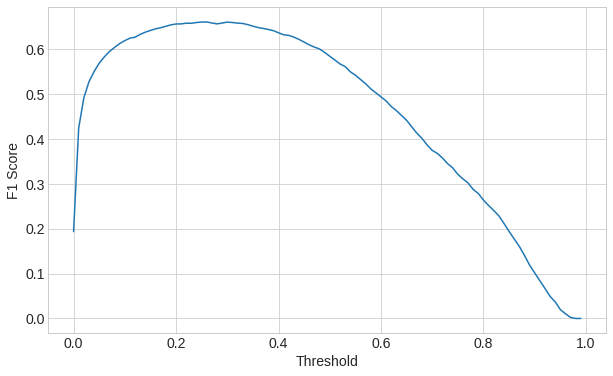

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Grouping Features**

In [ ]:
df['mean_age_for_customer_on_month_and_day_of_month'] = df.groupby('month_and_day_of_month')['customer_age'].transform('mean')
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.202053
[400]	valid_0's binary_logloss: 0.17671
[600]	valid_0's binary_logloss: 0.16704
[800]	valid_0's binary_logloss: 0.163316
[1000]	valid_0's binary_logloss: 0.161244
[1200]	valid_0's binary_logloss: 0.160354
[1400]	valid_0's binary_logloss: 0.160107
[1600]	valid_0's binary_logloss: 0.159898
[1800]	valid_0's binary_logloss: 0.159865
[2000]	valid_0's binary_logloss: 0.159911
Early stopping, best iteration is:
[1705]	valid_0's binary_logloss: 0.159833

F1 score for validation set is 0.5842880523731587

------------- Fold 2 -------------
Training until validation scores don't improve for 400 rounds.
[200]	valid_0's binary_logloss: 0.199161
[400]	valid_0's binary_logloss: 0.173862
[600]	valid_0's binary_logloss: 0.164341
[800]	valid_0's binary_logloss: 0.160841
[1000]	valid_0's binary_logloss: 0.158901
[1200]	valid_0's binary_logloss: 0.158041
[1400]	valid

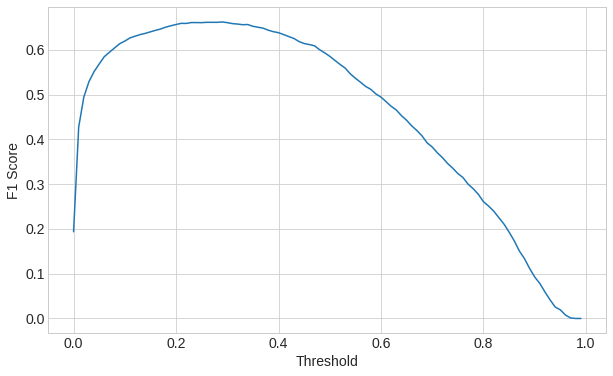

In [ ]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.38,
                        reg_alpha = 1,
                        reg_lambda = 1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 400}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

In [ ]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_fe_freq_grouped.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Ensembling**

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.



* What are our best performing algorithms ?
* How do we combine these algorithms to get a better performance ?

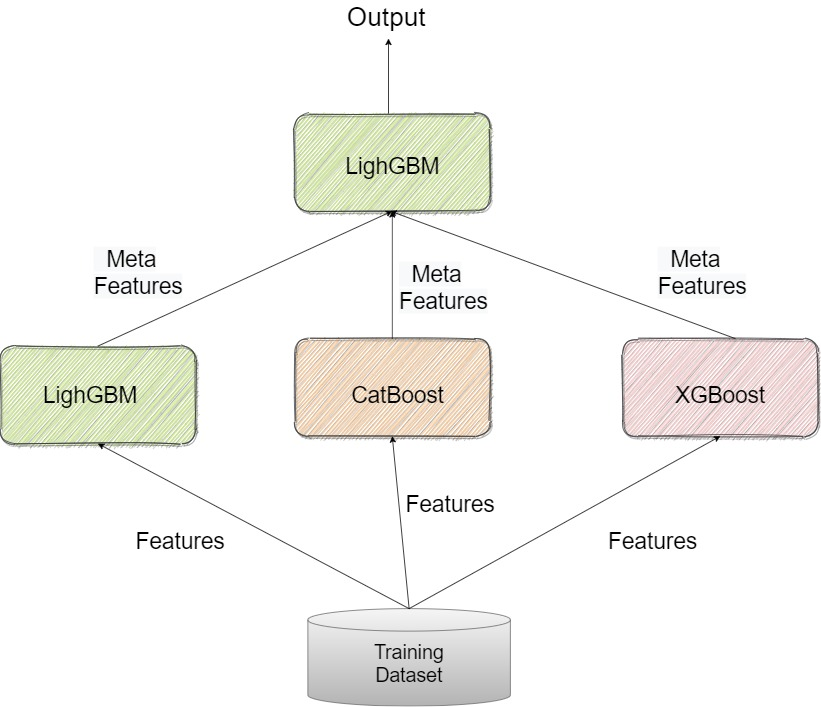

https://courses.analyticsvidhya.com/courses/ensemble-learning-and-ensemble-learning-techniques

In [ ]:
train_new = train[[ID_COL, TARGET_COL]]
test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
features

['lgb', 'cb', 'xgb']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.166744
[400]	valid_0's binary_logloss: 0.157022
[600]	valid_0's binary_logloss: 0.156442
Early stopping, best iteration is:
[554]	valid_0's binary_logloss: 0.156391

F1 score for validation set is 0.6134185303514378

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.164457
[400]	valid_0's binary_logloss: 0.154572
[600]	valid_0's binary_logloss: 0.153962
Early stopping, best iteration is:
[574]	valid_0's binary_logloss: 0.15394

F1 score for validation set is 0.6297739672642244

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.167124
[400]	valid_0's binary_logloss: 0.158289
[600]	valid_0's binary_logloss: 0.157992
Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.157857

F1 s

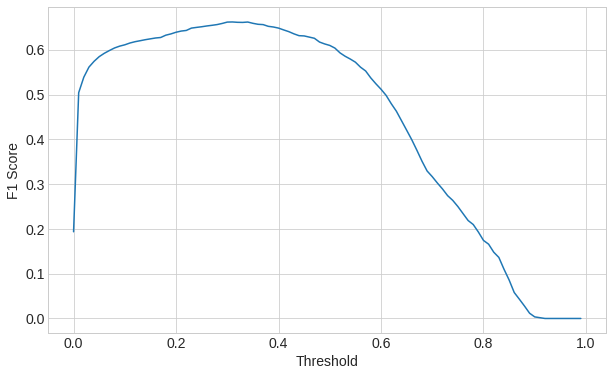

In [ ]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.75,
                        reg_alpha=1,
                        reg_lambda=1,
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_new, test_new, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

# Conclusions:



1. LightBGMu has produced very good results than any other.
2. There is chance in increase in the efficiency of model by feature engineering
3. Threshold optimization helped in achieving good results.